In [91]:
#Import functions and libraries from scripts
from GP_funcs import *
from file_opening import *
from SCB_conversion import SCB_CONVERSION

import string

#for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# import matplotlib.patheffects as pe
# for exporting things as mat for matlab
import scipy.io

# For linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# For kernel covariance matrix
import seaborn as sns

In [139]:
'''User set values for code blocks to run '''
p = 100 #number of points wanted for GP's
colr_sc = ['#1E77B4','#FCAF38',"#BFD061"] #Color scheme
USGS_site_id = ['05325000','05325300','05330000']
markers = ['s', 'o','^', 'D']
labels = list(string.ascii_uppercase)
alpha_site_id = labels[0:len(USGS_site_id)]

plt.rcParams.update({'font.size': 12})

# create_USGS_dfs('sensor', USGS_site_id) 

# Load USGS site data and SAC

In [140]:
#Load USGS data
# numbers for easy enumeration
site_numbs = np.arange(len(USGS_site_id))
# updates ADVM and grab_samples readings to included calculated SAC and SSC already and calucated dq/dt for samples
ADVM_readings = create_USGS_dfs('sensor', USGS_site_id) #Sensor readings for all sites
Grab_samples = create_USGS_dfs('samples', USGS_site_id) #Grab samples and flow for all sites
Qall_time = create_USGS_dfs('Qall', USGS_site_id) #Discharge for total time range of sensor deployment per site


dfc = pd.read_csv(r'USGS_data/USGS_site_consts.csv') # Read in constants for all sites
dfc['Site_ID'] = dfc['Site_ID'].map(toName) #Converts Site_ID to string type

data_dictionary = {} # empty dictionary to put dataframes into, keys are site id
for i, id in enumerate(USGS_site_id):
    #Selects constants for each USGS site
    Consts = dfc.loc[dfc['Site_ID'] ==  id].iloc[0, 1:]

    data_dictionary[alpha_site_id[i]] = { 'USGS_id' : id,
                            'ADVM' : ADVM_readings[id],
                            'Samples' : Grab_samples[id],
                            'Flow' : Qall_time[id],
                            'Consts' : Consts # This is a pandas series
                        }

In [141]:
print(f"Data dictionary keys: {data_dictionary['A']['Samples']['SSC']}")

Data dictionary keys: 0      386.0
1      287.0
2      366.0
3      222.0
4      137.5
5      241.0
6      520.0
7      306.0
8      176.0
9     1191.0
10    1150.0
11     503.0
12     145.0
13     139.0
14     308.0
15     364.0
16     351.0
17     446.0
18      66.0
19     833.0
Name: SSC, dtype: float64


# Functions

## Gaussian Process

In [142]:
def GP(SAC_m, SSC_m, p, SAC_range = [None,None], SAC_log=False, SSC_log=False, hyperparams = -999):
    #assuming don't want log value (and pass regular values)
    #option to pass in hyperparameters -> it is a 2 element list where the first is the rbf (squared exponentia - l) length scale, the second is the white noise level
    # Combination of RBF and whitekernel set to optimize hyperparameters
    if hyperparams == -999:
        kernel = RBF() + WhiteKernel()
    else:
        l, nw = hyperparams
        kernel = RBF(l, length_scale_bounds="fixed") + WhiteKernel(nw, noise_level_bounds="fixed")

    # Calculate range for model run 
        #safety measure if not put in correct order and if passed as list with wiggle room
    if SAC_range != [None,None]:
        min_SAC = np.array(SAC_range).min()-(0.1*np.array(SAC_range).min())
        max_SAC = np.array(SAC_range).max()+(0.1*np.array(SAC_range).max())
    else:
        min_SAC = SAC_m.min()
        max_SAC = SAC_m.max()    

    #Set variables for training
    X = np.array(SAC_m).reshape(-1,1)
    y = SSC_m #hand made for scale 2
    
    #Change to log based if output desired is in log and calucate range
    if SAC_log == True:
        min_SAC = np.log10(min_SAC)
        max_SAC = np.log10(max_SAC)
        X = np.log10(np.array(SAC_m).reshape(-1,1))
    if SSC_log == True:
         y = np.log10(SSC_m) 

    #Make range for SAC prediction
    SAC_pred = np.linspace(min_SAC,max_SAC,p)

    #Create model from training data
    # https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html
    gaussian_proccess = GaussianProcessRegressor(kernel=kernel, normalize_y = True)
    gpr = gaussian_proccess.fit(X,y)
    gaussian_proccess.kernel_
    GP_score = gpr.score(X,y) # I don't think this means anything. because it seems like it's train x and test x??
    GP_logmarg = gpr.log_marginal_likelihood()
    
    #Make predicted model from kernel
    [Y_pred, std] = gpr.predict(SAC_pred.reshape(-1, 1) , return_std = True)

    # how to get kernel with optimized hyperparameters: gaussian_proccess.kenerl_.theta
    return (SAC_pred, Y_pred, std, GP_score, GP_logmarg, gaussian_proccess)


In [143]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import (
    RBF, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic
)

# Helper to extract hyperparameters from composite kernel

def extract_kernel_hyperparams(kernel):
    params = {}

    def _extract(k, prefix=''):
        if hasattr(k, 'theta') and hasattr(k, 'hyperparameter_names'):
            for name, val in zip(k.hyperparameter_names, np.exp(k.theta)):
                params[f"{prefix}{name}"] = val
        if hasattr(k, 'k1'):
            _extract(k.k1, prefix + 'k1_')
        if hasattr(k, 'k2'):
            _extract(k.k2, prefix + 'k2_')

    _extract(kernel)
    return params

# Gaussian Process Regression function

def GP(SAC_m, SSC_m, p, SAC_log=False, SSC_log=False, hyperparams=-999):
    # ---- Normalize x using min-max ----
    min_SAC = SAC_m.min()
    max_SAC = SAC_m.max()
    x_range = max_SAC - min_SAC
    if x_range < 1e-8:
        raise ValueError("Input x has too small a range to normalize reliably.")
    X = ((SAC_m - min_SAC) / x_range).reshape(-1, 1)

    # ---- Normalize y using min-max ----
    min_SSC = SSC_m.min()
    max_SSC = SSC_m.max()
    y_range = max_SSC - min_SSC
    if y_range < 1e-8:
        raise ValueError("Target y has too small a range to normalize reliably.")
    y = ((SSC_m - min_SSC) / y_range).reshape(-1, 1)

    if SAC_log:
        X = np.log10(X + 1e-8)
    if SSC_log:
        y = np.log10(y + 1e-6)

    # Kernel setup
    input_mean = np.abs(np.mean(X))
    noise_std = max(np.std(y), 1e-6)

    if hyperparams == -999:
        kernel = (
            ConstantKernel(0.3, (0.05, 0.8)) *
            RBF(length_scale=0.5, length_scale_bounds=(0.3, 2)) 
            # DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1 , 2))
            # RationalQuadratic(length_scale=0.5, length_scale_bounds=(0.3, 1),
            #                  alpha=1.0, alpha_bounds=(0.1, 100.0)) 
        )
    else:
        l = hyperparams[0]
        kernel = RBF(l, length_scale_bounds="fixed")

    SAC_pred = np.linspace(0, 1, p).reshape(-1, 1)

    # Fit with cross-validated alpha
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=False)
    # since envrionmental data, trying to find best alpha (noise) but have it not be too low
    alphas = np.logspace(-2, -1, 10)
    search = GridSearchCV(gp, {'alpha': alphas}, cv=5)
    search.fit(X, y.ravel())

    best_alpha = search.best_params_['alpha']
    gp_best = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=best_alpha)
    gp_best.fit(X, y.ravel())

    Y_pred_scaled, std_scaled = gp_best.predict(SAC_pred, return_std=True)

    # Invert y-scaling
    Y_pred_orig = Y_pred_scaled * y_range + min_SSC
    std_orig = std_scaled * y_range

    # Invert x-scaling for plotting
    SAC_pred_orig = SAC_pred.ravel() * x_range + min_SAC

    score = gp_best.score(X, y.ravel())
    log_marg = gp_best.log_marginal_likelihood()

    return SAC_pred_orig, Y_pred_orig, std_orig, score, log_marg, gp_best, best_alpha, (min_SAC, x_range), (min_SSC, y_range)


# Example usage (replace with your actual loop logic)
model_dictionary = {}
x_key = 'SAC'
y_key = 'SSC'

for i, site_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]['Samples']
    # print(site_data.keys())
    # print(site_data.keys())
    
    # Scatter plot
    xdata = np.array(site_data[x_key])
    ydata = np.array(site_data[y_key])
    print(site_id, xdata, ydata)

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model, n_alpha, x_scale, y_scale = GP(xdata, ydata, p)
    kernel_params = extract_kernel_hyperparams(GP_model.kernel_)
    x_min, x_range = x_scale
    x_scaled = (xdata - x_min) / x_range
    ypred_scaled, std_pred_scaled = GP_model.predict(x_scaled.reshape(-1, 1), return_std=True)
    
    y_min, y_range = y_scale
    ypred = ypred_scaled * y_range + y_min
    std_pred = std_pred_scaled * y_range

    MSE_all = np.square(np.subtract(ydata, ypred)).mean()
    rmse_all = math.sqrt(MSE_all)
    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))
    print(f"Site {site_id} - RMSE: {rmse_all:.2f}, R^2: {r_score_all:.2f}, Alpha: {n_alpha}")

    model_dictionary[site_id] = {
        'hyperparams': kernel_params,
        'num_samp': len(xdata),
        'x': xdata,
        'y': ydata,
        'n_pred': ypred,
        'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
        'scores': {
            'GP_score': GP_score_all,
            'GP_logmarg': GP_logmarg_all,
            'r_score': r_score_all,
            'rmse': rmse_all,
            'std': std_pred,
            'alpha': n_alpha,
        },
        'model': GP_model,
        'x_scaling': x_scale,  # (min_SAC, x_range)
        'y_scaling': y_scale,  # (min_SSC, y_range)
    }



A [1.26721015 1.32127946 1.31394716 0.80759126 0.54584746 0.71134633
 1.22040495 0.69722757 0.52350769 1.59055352 1.37598444 1.03334167
 0.60315934 0.74045886 1.08146695 1.14763104 1.07011739 1.21238934
 0.50779616 1.11103744] [ 386.   287.   366.   222.   137.5  241.   520.   306.   176.  1191.
 1150.   503.   145.   139.   308.   364.   351.   446.    66.   833. ]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.3. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/

Site A - RMSE: 214.67, R^2: -1.78, Alpha: 0.1
B [1.26567704 1.32183596 1.21300983 0.91092152 0.72643172 0.6535379
 1.22438573 0.91187757 0.7291864  0.71611927 1.98931588 1.65204932
 0.98544044 0.87003789 0.94392123 1.2592935  1.30139913 1.31298998
 1.38638257 1.25423791 0.56555196 1.35604495] [ 305  332  360  246  173  188  565  332  189  128 1620  930  344  195
  204  296  344  352  418  365   83  781]


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

Site B - RMSE: 100.92, R^2: -1.45, Alpha: 0.01
C [0.79102913 0.84256709 0.78471862 0.50370576 0.55501959 1.68865786
 0.45561461 0.50052758 0.41172928 0.38068765 0.5002159  0.4440302
 0.63347193 0.74425062 0.91018902 0.8125168  0.88188531 0.93698205
 0.40676942 0.77960587 0.71733819] [ 268  312  381  174  247 1390  343  240  210   67  147  180  234  330
  406  411  627  538   81  570  615]
Site C - RMSE: 104.42, R^2: -1.76, Alpha: 0.01


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.05. Decreasing the bound and calling fit again may find a better value.
  warnings.wa

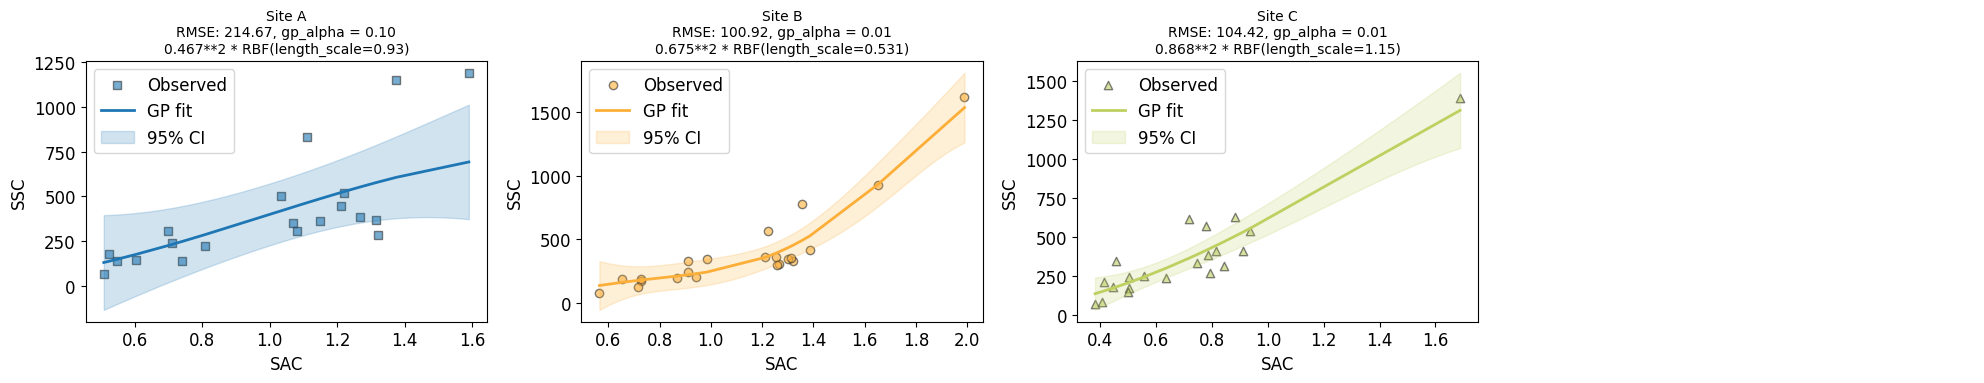

In [144]:
x_key = 'SAC'
y_key = 'SSC'

site_ids = list(model_dictionary.keys())
n_sites = len(site_ids)
n_cols = 4
n_rows = math.ceil(n_sites / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, site_id in enumerate(site_ids):
    ax = axes[i]
    model = model_dictionary[site_id]

    xdata = model['x']
    ydata = model['y']
    ypred = model['n_pred']
    SAC_pred_all, SSC_pred_all, std_all = model['p_pred']
    rmse = model['scores']['rmse']
    gp_alpha = model['scores']['alpha']

    # Sort for smooth plotting
    sorted_indices = np.argsort(xdata)
    x_sorted = xdata[sorted_indices]
    y_sorted = ypred[sorted_indices]
    std_sorted = std_all[sorted_indices] if isinstance(std_all, np.ndarray) else np.array(std_all)[sorted_indices]

    # Plot
    color = colr_sc[i % len(colr_sc)]  # wrap around if more sites than colors
    marker = markers[i % len(markers)] if 'markers' in globals() else 'o'

    ax.scatter(xdata, ydata, color=color, marker=marker, edgecolors='#2E2E2E', alpha=0.6, label='Observed')
    ax.plot(x_sorted, y_sorted, color=color, linewidth=2, label='GP fit')
    # ax.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, alpha=0.2, color=color)
    ax.fill_between(SAC_pred_all,
                SSC_pred_all - 1.96 * std_all,
                SSC_pred_all + 1.96 * std_all,
                color=color, alpha=0.2, label='95% CI')

    try:
        kernel_str = str(model['model'].kernel_)
    except Exception as e:
        kernel_str = f"Kernel: Unknown ({e})"

    ax.set_title(
        f"Site {site_id}\nRMSE: {rmse:.2f}, gp_alpha = {gp_alpha:.2f}\n{kernel_str}",
        fontsize=10
    )

    # ax.set_title(f'Site {site_id}\nRMSE: {rmse:.2f}')
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    ax.legend()

# Turn off unused subplots
for j in range(len(site_ids), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Covariance matrix to correlation matrix

In [145]:
def cov_to_cor(cov):
    # get diagonal elements from covaraince matrix
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v,v)
    cor = cov/outer_v
    cor[cov == 0] = 0
    return cor

### make kernel matrix function of k(xi, xj)

In [146]:
# make my own kernel matrix function of k(xi,xj)

def rbf_ker(x,y,l):
    k = math.exp(- math.dist([x],[y]) / (2*l**2) )
    return k

# Linear fits

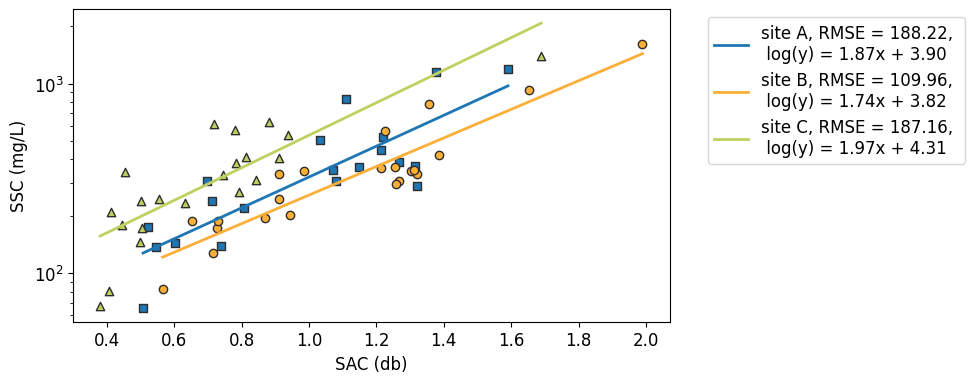

In [147]:
plt.figure(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    colr = colr_sc[i]
    mod = data_dictionary[id]['Samples']
    
    # Scatter plot
    x = np.array(mod['SAC']).reshape(-1, 1)
    y = np.array(mod['SSC']).reshape(-1, 1)
    plt.scatter(x, y, color=colr, marker=markers[i], edgecolors='#2E2E2E', zorder=1)
    
    # Use log of y for linear regression
    log_y = np.log(y)
    
    # Linear regression
    model = LinearRegression()
    model.fit(x, log_y)
    log_y_pred = model.predict(x)
    
    # Sort the data for plotting
    sorted_indices = np.argsort(x.ravel())
    x_sorted = x[sorted_indices]
    log_y_pred_sorted = log_y_pred[sorted_indices]
    
    # Calculate the slope and intercept
    slope = model.coef_[0, 0]
    intercept = model.intercept_[0]
    
    # Calculate RMSE using log values
    log_rmse = np.sqrt(mean_squared_error(log_y, log_y_pred))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(np.exp(log_y), np.exp(log_y_pred)))
    
    # Plot the fitted line in the original scale
    plt.plot(x_sorted, np.exp(log_y_pred_sorted), linewidth=2, color=colr, 
             label=f'site {id}, RMSE = {rmse:.2f}, \n log(y) = {slope:.2f}x + {intercept:.2f}')

plt.yscale('log')
plt.xlabel('SAC (db)')
plt.ylabel('SSC (mg/L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/linear_fit.png' , dpi=500) 

plt.show()



# Gaussian baseline models

## uses all grabs samples at given site to train a model for that site

A: l = 0.57, nl = 0.51
B: l = 0.41, nl = 0.12
C: l = 0.58, nl = 0.18


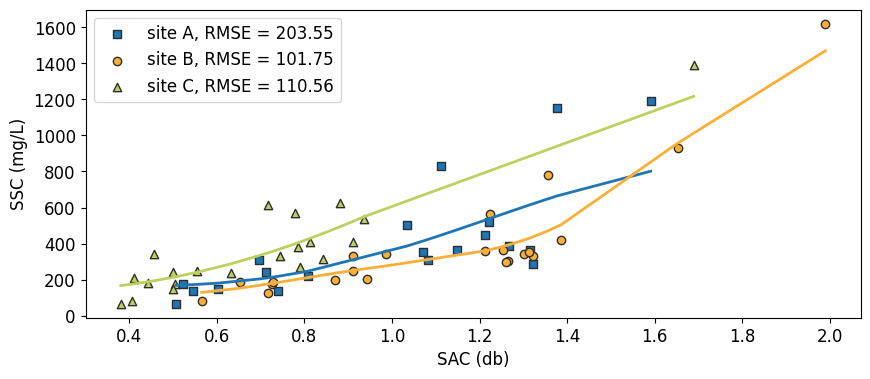

In [8]:
model_dictionary = {}

plt.figure(figsize=(10, 4))


#Run GP using all data
# for by site, optimizing hyperparameters -> stored by USGS site name
for i, id in enumerate(alpha_site_id):
    site_data = data_dictionary[id]
    xdata = site_data['Samples']['SAC'].to_numpy()
    ydata = site_data['Samples']['SSC'].to_numpy()

    SAC_pred_all, SSC_pred_all, std_all, GP_score_all, GP_logmarg_all, GP_model = GP(xdata, ydata, p)  
    # obtains length scales of rbf and noise level for white kernel from trained GP model
    l,nw = np.exp(GP_model.kernel_.theta)
    print(f'{id}: l = {np.round(l,2)}, nl = {np.round(nw,2)}')
    # important ypred and ydata are sorted same order wrt xdata
    ypred, std_pred = GP_model.predict(xdata.reshape(-1, 1), return_std=True, return_cov=False)
    MSE_all = np.square(np.subtract(ydata,ypred)).mean() 
    rmse_all = math.sqrt(MSE_all)

    r_score_all = GP_model.score(ypred.reshape(-1, 1), ydata.reshape(-1, 1))

    # Sort xdata and reorder ypred to match
    sorted_indices = np.argsort(xdata)
    x_sorted = np.array(xdata)[sorted_indices]
    y_sorted = np.array(ypred)[sorted_indices]
    std_sorted = np.array(std_pred)[sorted_indices]

    plt.scatter(xdata, ydata, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', zorder=1, label=f'site {id}, RMSE = {rmse_all:.2f}')
    plt.plot(x_sorted, y_sorted, color=colr_sc[i], linewidth=2)   
    # plt.fill_between(x_sorted, y_sorted - 1.96 * std_sorted, y_sorted + 1.96 * std_sorted, color=colr_sc[i], alpha=0.2)

    plt.xlabel('SAC (db)')
    plt.ylabel('SSC (mg/L)')
    plt.legend()
    # plt.savefig(f'figures/GP_baselinemodel.png', dpi=500)

    model_dictionary[id] = {    'hyperparams': {
                                    'rbf_l' : l,
                                    'noise_l' : nw,
                                },
                                'x': xdata,
                                'y': ydata,
                                'n_pred': ypred,
                                'p_pred': [SAC_pred_all, SSC_pred_all, std_all],
                                # 'scores': [GP_score_all, GP_logmarg_all, r_score_all, rmse_all],
                                'scores': {
                                    'GP_score':GP_score_all, 
                                    'GP_logmarg':GP_logmarg_all,
                                    'r_score': r_score_all, 
                                    'rmse' : rmse_all, 
                                    'std': std_pred
                                },
                                'model': GP_model
                                }
    
plt.show()


## All kernels on all sites permutations

In [9]:
# Initialize the new dictionary
cross_prediction_dictionary = {site_id: {} for site_id in alpha_site_id}

# Loop through each combination of test and model sites
for model_id in alpha_site_id:
    for site_id in alpha_site_id:
        # Get the model from the model_dictionary
        GP_model = model_dictionary[model_id]['model']

        # Get the test site data
        test_data = data_dictionary[site_id]
        x_test = test_data['Samples']['SAC'].to_numpy()
        y_test = test_data['Samples']['SSC'].to_numpy()

        # Use the model to predict SSC for the test data
        y_pred, std_pred = GP_model.predict(x_test.reshape(-1, 1), return_std=True)

        # Calculate scores
        MSE = np.square(np.subtract(y_test, y_pred)).mean()
        rmse = math.sqrt(MSE)
        r_score = GP_model.score(y_pred.reshape(-1, 1), y_test.reshape(-1, 1))

        # Store the results in the new dictionary
        cross_prediction_dictionary[site_id][model_id] = {
            'hyperparams': {
                'rbf_l' : l,
                'noise_l' : nw,
            },
            'x': xdata,
            'y': ydata,
            'n_pred': ypred,
            'scores': {
                'r_score': r_score, 
                'rmse' : rmse, 
                'std': std_pred
            },
            'model': GP_model
                                           
        }

In [10]:

print("RMSE for all sites with different models used to predict on it:")

for site_id in alpha_site_id:
    print(f"\nTest Site: {site_id}")
    # base_r, base_rmse = model_dictionary[site_id]['scores'][2:4]
    # print(f"  Baseline from Site {site_id}: RMSE = {base_rmse:.2f}; R = {base_r:.2f}")

    for i, model_id in enumerate(alpha_site_id):
        rmse = cross_prediction_dictionary[site_id][model_id]['scores']['rmse']
        r = cross_prediction_dictionary[site_id][model_id]['scores']['r_score']
        print(f"  Model from Site {model_id}: RMSE = {rmse:.2f}")


RMSE for all sites with different models used to predict on it:

Test Site: A
  Model from Site A: RMSE = 203.55
  Model from Site B: RMSE = 219.78
  Model from Site C: RMSE = 320.21

Test Site: B
  Model from Site A: RMSE = 232.50
  Model from Site B: RMSE = 101.75
  Model from Site C: RMSE = 415.51

Test Site: C
  Model from Site A: RMSE = 205.14
  Model from Site B: RMSE = 209.48
  Model from Site C: RMSE = 110.56


# optimal sample selection

## Creating the covariance matrix for each site

### Compute matrix for each site, specifiying n points

In [ ]:
# Initialize the dictionary to store results
correlation_matrices = {}
n_range = [20, 25, 50, 100]  # Number of points for covariance matrix

# Loop through all sites using alpha_site_id
for id in alpha_site_id:
    # initialize dictionary for site
    correlation_matrices[id] = {}
    # Read in values from the past dictionaries
    mod = model_dictionary[id]
    x = mod['x']
    y = mod['y']
    pred_x = mod['p_pred'][0]
    pred_y = mod['p_pred'][1]
    rmse = mod['scores']
    l = mod['hyperparams']['rbf_l']
    nw = mod['hyperparams']['noise_l']

    # Sort data
    ord = np.argsort(x)
    x_sort = x[ord]
    y_sort = y[ord]

    ''' 
    For n point range
    '''
    correlation_matrices[id]['n'] = {}
    for n in n_range: 
        # Make evenly spaced array of length n to predict the model with
        nx_trend = np.linspace(np.min(x_sort) - 0.05, np.max(x_sort) + 0.5, n)

        # Initialize the RBF kernel matrix
        rbf = np.zeros((n, n))

        # Compute the RBF kernel matrix
        for i, x in enumerate(nx_trend):
            for j, y in enumerate(nx_trend):
                rbf[i, j] = rbf_ker(x, y, l)

        # Add white noise to the diagonal
        wn = np.identity(n) * nw
        kernnie = rbf + wn

        # Compute the correlation matrix
        cor_mat = cov_to_cor(kernnie)

        # Store the correlation matrix in the dictionary
        correlation_matrices[id]['n'][n] = {
                'hyperparams': {
                    'rbf_l' : l,
                    'noise_l' : nw,
                },
                'cor_matrix' : cor_mat,
                'range' : nx_trend,
        }

    ''' 
    For num samples range across all sites 
    '''
    correlation_matrices[id]['num_samp'] = {}
    for model_id in alpha_site_id:        
        # Still using the target site readings
        samp_n = len(x_sort)

        # grab the length scales for the model site
        ker = model_dictionary[model_id]['hyperparams']
        l = ker['rbf_l']
        nw = ker['noise_l']
        # Initialize the RBF kernel matrix
        rbf = np.zeros((samp_n, samp_n))

        # Compute the RBF kernel matrix
        for i, x in enumerate(x_sort):
            for j, y in enumerate(x_sort):
                rbf[i, j] = rbf_ker(x, y, l)

        # Add white noise to the diagonal
        wn = np.identity(samp_n) * nw
        kernnie = rbf + wn

        # Compute the correlation matrix
        cor_mat = cov_to_cor(kernnie)

        # Store the correlation matrix in the dictionary
        correlation_matrices[id]['num_samp'][model_id] = {
                'hyperparams': {
                    'rbf_l' : l,
                    'noise_l' : nw,
                },
                'cor_matrix' : cor_mat,
                'range': x_sort,
                'n' : samp_n,
        }

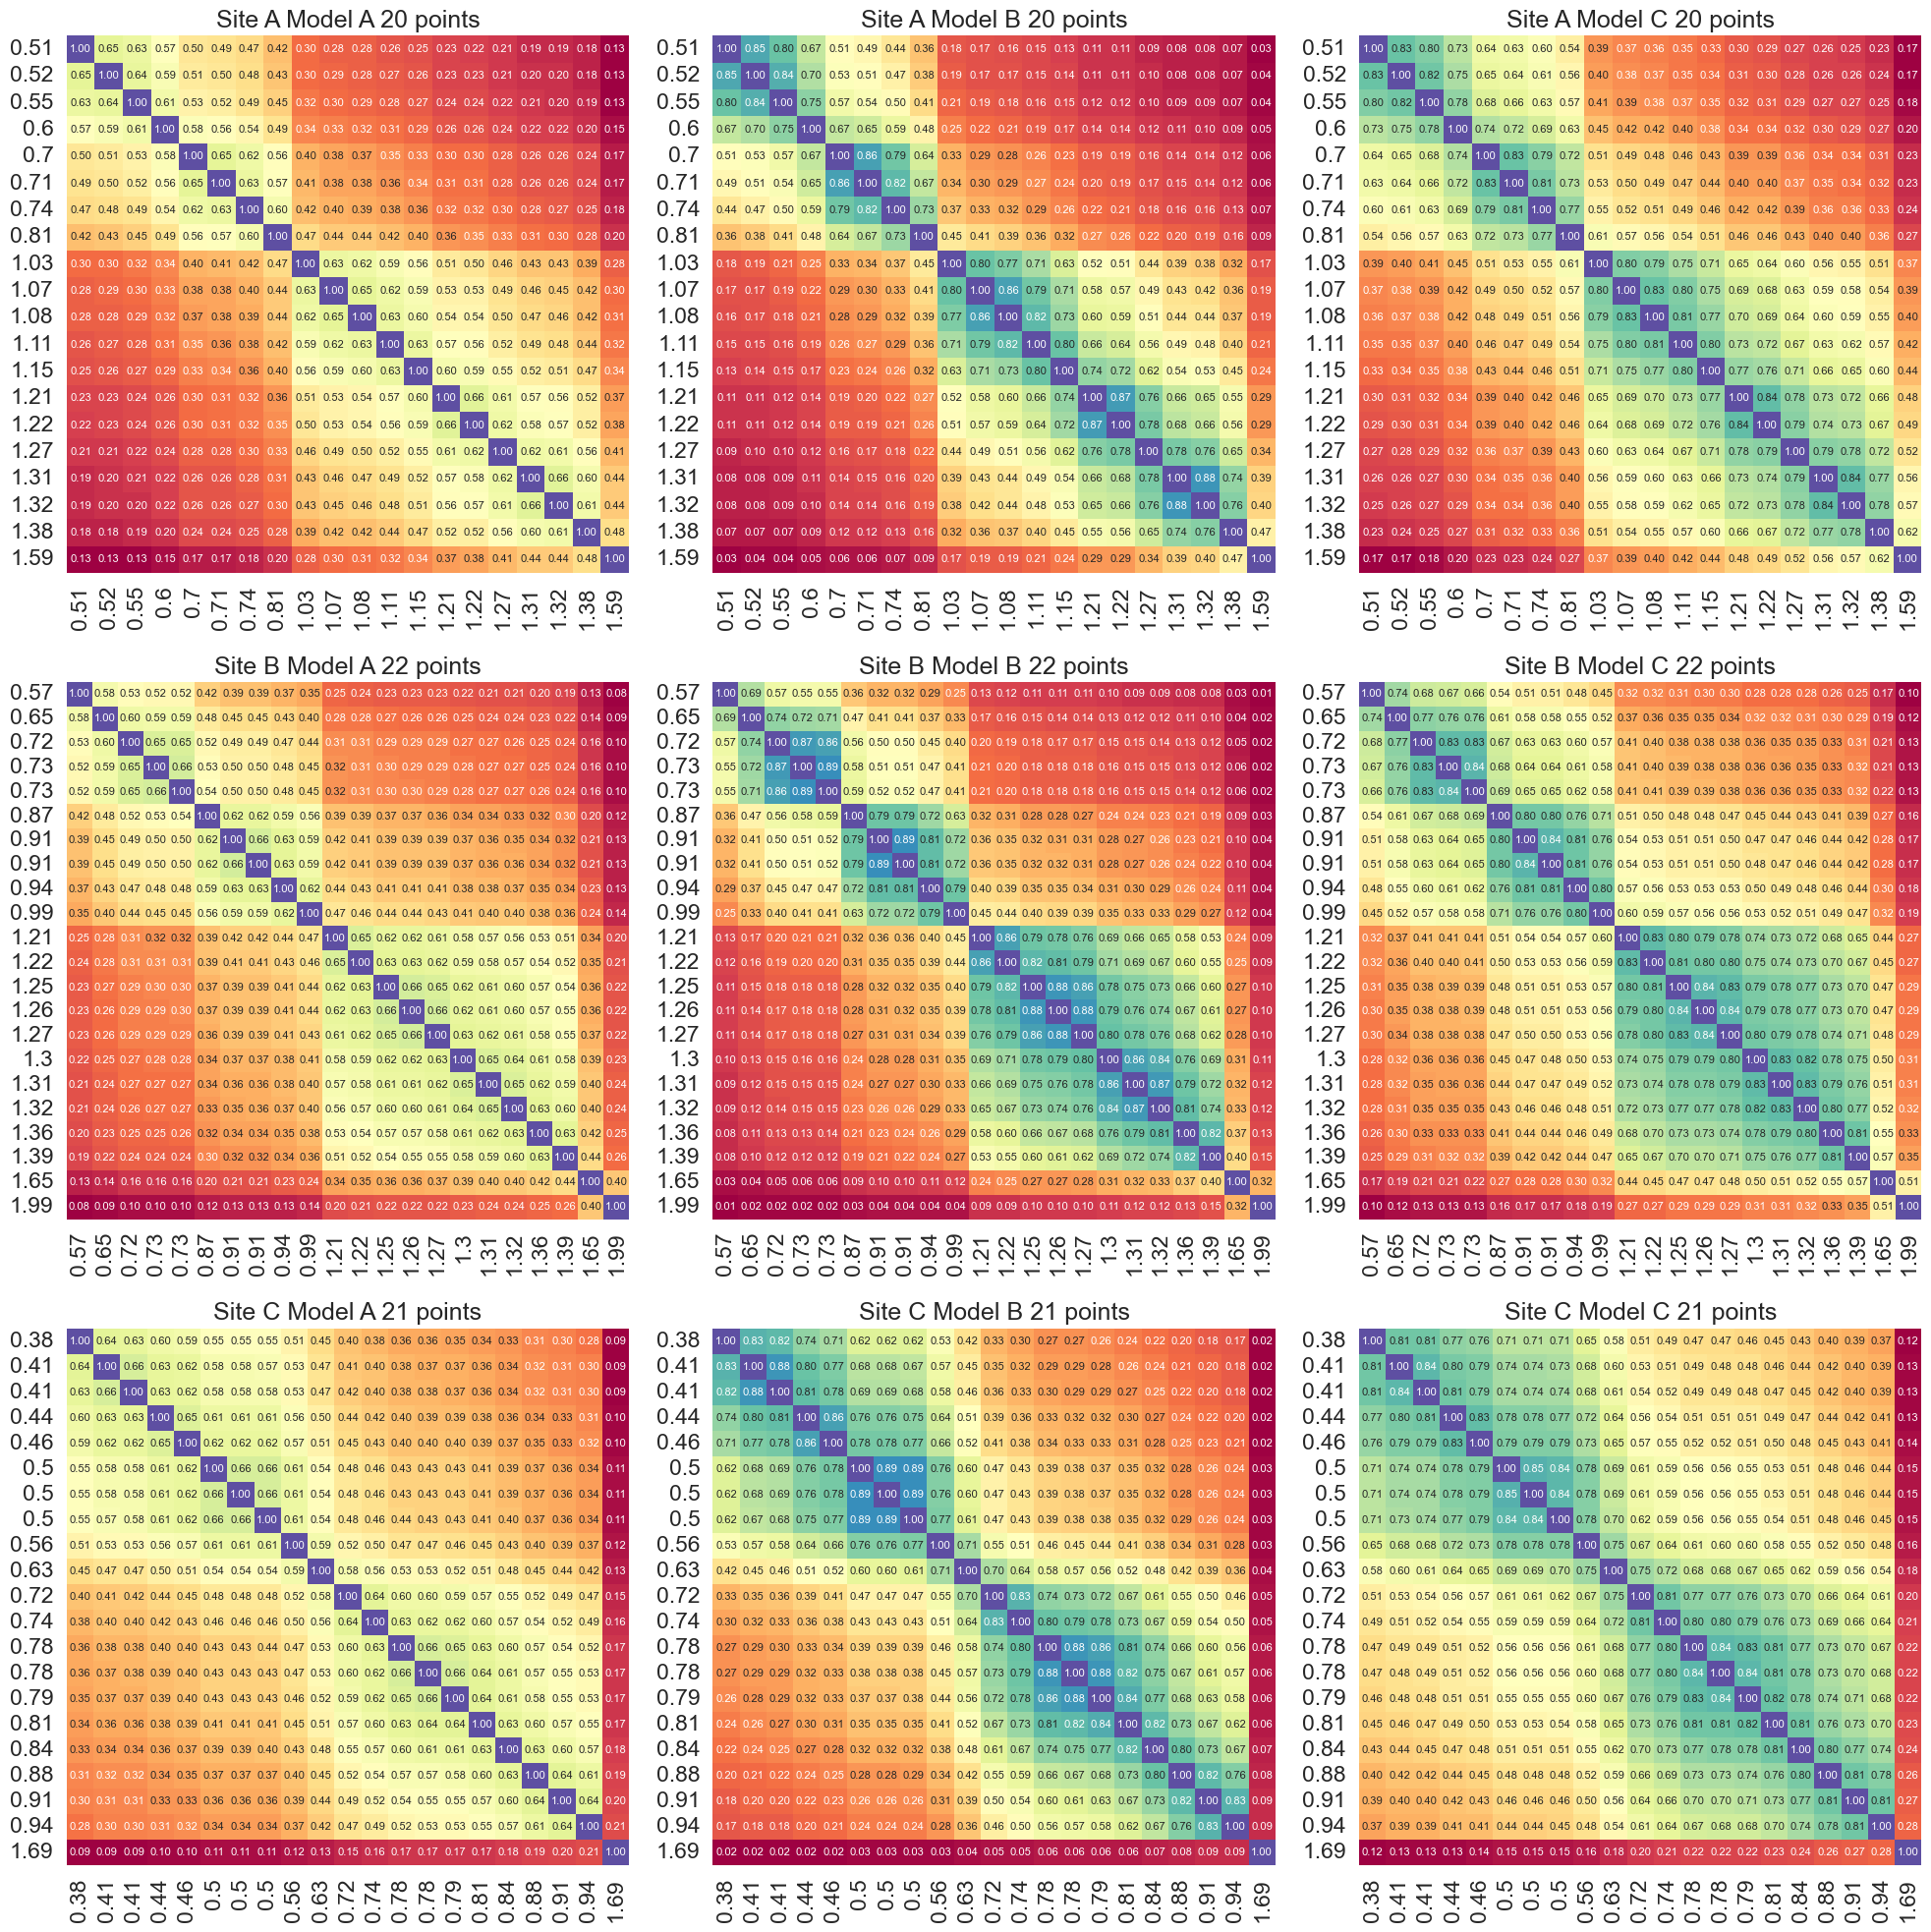

In [54]:
# Plotting the correlation matrices in a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

index = 0
for id, models in correlation_matrices.items():
    for model_id, data in models['num_samp'].items():
        if index >= len(axes):
            break
        
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        mask_lt = np.triu(np.ones(cor_mat.shape), k=1).astype(bool)

        sns.set(font_scale=1.5)
        sns.heatmap(
            np.round(cor_mat, 2),
            # mask=mask_lt,
            cbar=False,
            annot=True,
            # square=True,
            cmap="Spectral",
            fmt='.2f',
            annot_kws={'size': 8},
            yticklabels=np.round(np.sort(nx_trend), 2),
            xticklabels=np.round(np.sort(nx_trend), 2),
            ax=axes[index]
        )
        axes[index].set_title(f'Site {id} Model {model_id} {len(nx_trend)} points')
        index += 1

# Hide any unused subplots
for j in range(index, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### save to ".mat" to use in matlab

In [23]:
# But really only care for the at site A, ker B and C
# import os

MATLAB_filepath = "GVR_USGS"
# do this to get the cor matrix
for id, models in correlation_matrices.items():
    print(f"data set: ")
    
    for model_id, data in models['num_samp'].items():
        print("model_id:" , model_id)
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        
        scipy.io.savemat(f'{MATLAB_filepath}/corr_samp{id}{model_id}.mat', {'cor_mat': cor_mat})
    scipy.io.savemat(f'{MATLAB_filepath}/xdata_samp{id}.mat', {'xdata': nx_trend})
    
    
    # save n samples too
    for n, data in models['n'].items():
        print("num_points:" , n)
        cor_mat = data['cor_matrix']
        nx_trend = data['range']
        
        scipy.io.savemat(f'{MATLAB_filepath}/corr_range{id}{n}.mat', {'cor_mat': cor_mat})
        scipy.io.savemat(f'{MATLAB_filepath}/xdata_range{id}{n}.mat', {'xdata': nx_trend})

# scipy.io.savemat(f'corr_samp{model_id}.mat', {'cor_mat': cor_mat})
# scipy.io.savemat(f'SAC_samp{id}.mat', {'SAC': x_sort})

data set: 
model_id: A
model_id: B
model_id: C
num_points: 20
num_points: 25
num_points: 50
num_points: 100
data set: 
model_id: A
model_id: B
model_id: C
num_points: 20
num_points: 25
num_points: 50
num_points: 100
data set: 
model_id: A
model_id: B
model_id: C
num_points: 20
num_points: 25
num_points: 50
num_points: 100


## Matlab results

In [28]:
# mat_file = scipy.io.loadmat('GVR_data_code/rangeA25.mat')
# print(mat_file['A'][0])
# print(mat_file['scores'][0])

""" read sample selection and scores given arbritrary SAC range """
range_selection = {}

for id in alpha_site_id:
    range_selection[id] = {}
    for n in n_range:
        range_selection[id][n] = {}
        dict = range_selection[id][n]
        mat_file = scipy.io.loadmat(f'GVR_USGS/range{id}{n}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]

""" read in sample selection out of grab samples we already have (permutating through each correlation matrix that was used to select samples) """
grabSamp_selection = {}

# selects site with grab samples used
for id in alpha_site_id:
    grabSamp_selection[id] = {}
    # cycle through kernel used
    for model_id in alpha_site_id:
        grabSamp_selection[id][model_id] = {}
        dict = grabSamp_selection[id][model_id] 
        mat_file = scipy.io.loadmat(f'GVR_USGS/samp{id}{model_id}.mat')
        dict['samples'] = mat_file['A'][0]-1 # for matlab to python indexing
        dict['score'] = mat_file['scores'][0]


## Plot elbow curves

### Plot for generic range

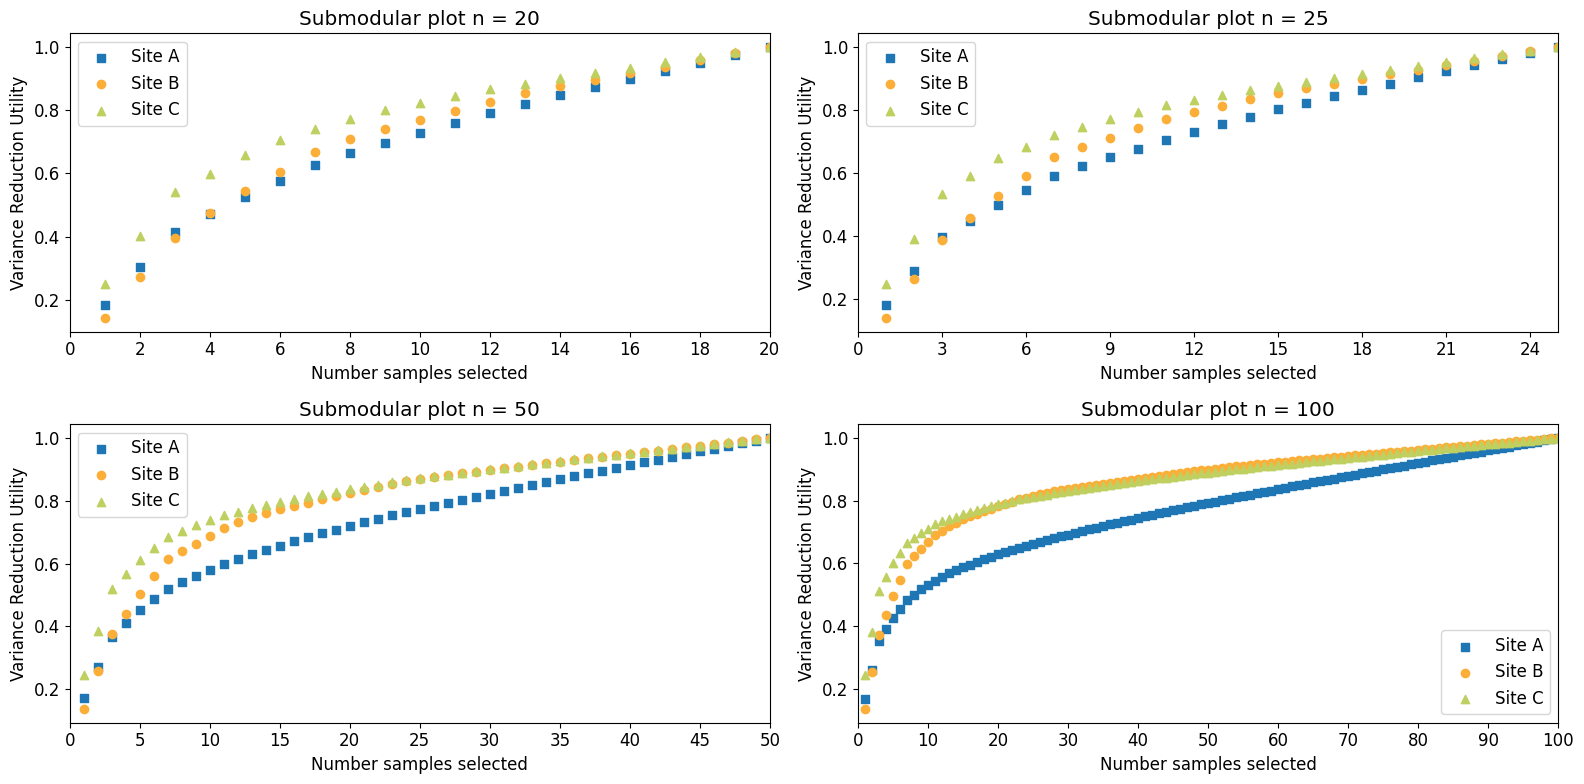

In [29]:
# Plotting the curves with subplots for each item in n_range
fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, n in enumerate(n_range):
    if idx >= len(axes):
        break  # In case n_range has more than 4 items

    ax = axes[idx]
    for i, id in enumerate(alpha_site_id):
        dict_data = range_selection[id][n]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Site {id}')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('Variance Reduction Utility')
    ax.set_title(f'Submodular plot n = {n}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if n_range has less than 4 items
for i in range(len(n_range), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

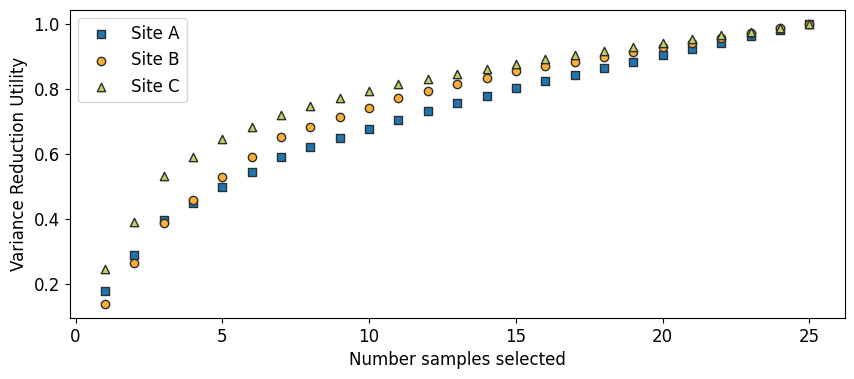

In [30]:
# plot only for n = 25

fig, ax = plt.subplots(figsize=(10, 4))

for i, id in enumerate(alpha_site_id):
    dict_data = range_selection[id][25]
    samples = dict_data['samples']
    scores = dict_data['score']
    
    # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
    x_axis = range(1, len(samples) + 1)
    
    # Plot the curve, preserving the relationship between samples and scores
    ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], edgecolors='#2E2E2E', label=f'Site {id}')


ax.set_xlabel('Number samples selected')
ax.set_ylabel('Variance Reduction Utility')
ax.legend()
# plt.savefig('figures/submod_n25.png', dpi=500)

### Plot for kernel permutation

A C plotted
B C plotted
C C plotted


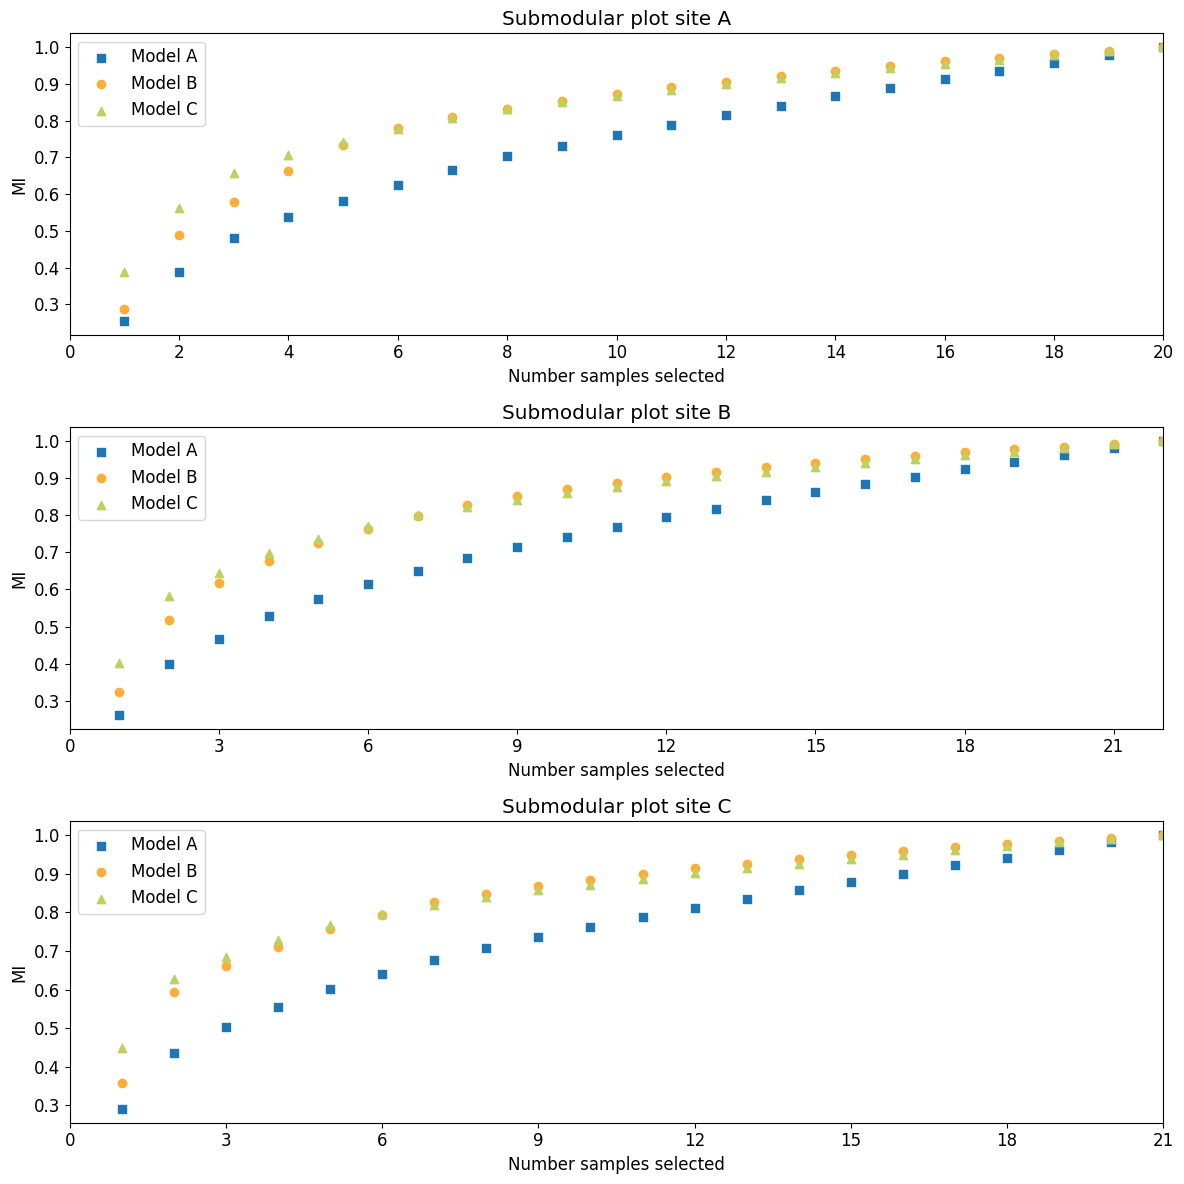

In [31]:
# Plotting the curves with subplots for each item in n_range
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for i, model_id in enumerate(alpha_site_id):
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']
        
        # Create a consistent x-axis since the samples is sample number, but we care about number of samples selected
        x_axis = range(1, len(samples) + 1)
        
        # Plot the curve, preserving the relationship between samples and scores
        ax.scatter(x_axis, scores, color=colr_sc[i], marker=markers[i], label=f'Model {model_id}')
    print(id, model_id, 'plotted')

    
    ax.set_xlabel('Number samples selected')
    ax.set_ylabel('MI')
    ax.set_title(f'Submodular plot site {id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xlim(0, len(samples))

# Hide any unused subplots if alpha_site_id has less than 3 items
for i in range(len(alpha_site_id), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Error plots

## Calculating for optimal selection

### Start at 2 samples to train model, increase to 15, always test with remaining amount

In [32]:
# make array of sample order 
for idx, id in enumerate(alpha_site_id):
    if idx >= len(axes):
        break  # In case id_range has more than 9 items

    ax = axes[idx]
    for model_id in alpha_site_id:
        dict_data = grabSamp_selection[id][model_id]
        samples = dict_data['samples']
        scores = dict_data['score']

        print(samples)

[11  3 17  6 19  0 13  8  7 18  2 10  4 15 12  1 16  5  9 14]
[13  4  1  9 17 19  7 12  3 18  8  6 15  0 11  2  5 14 16 10]
[11  3 17  6 19  0 14  8  7 18  4  2 10 15 12  1  5 13 16  9]
[13  3  7 18 21  0 10 20  9 16  1  5 19  2 12  8 15 11  4  6 17 14]
[14  3  7 18 21  0 20 10  9 16  1  5 19  8 12  2 15 11 17  4  6 13]
[13  3  7 20 17 21  0  9 19 10  1  5 15  2  8 11 18 14  4  6 16 12]
[12  4 18  7 20  0 10 16  8 19  2  9 14  5 17 11  1 15  3  6 13]
[13  4 18 20  7  1  9 10 16  8  0 19 15 11 17  5  3 12  2 14  6]
[12  4 18 20  7  0 10 16  9  2 19  8 14  5 17 11  3 15  1  6 13]


In [33]:
all_data = model_dictionary[site_id]
all_x = all_data['x']
all_y = all_data['y']

baseline_rmse = all_data['scores']['rmse']

In [34]:
optimal_dictionary = {}

for i, site_id in enumerate(alpha_site_id):
    # site_data = data_dictionary[site_id]
    # all model data
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    baseline_l = all_data['hyperparams']['rbf_l']
    baseline_nw = all_data['hyperparams']['noise_l']

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]


    optimal_dictionary[site_id] = { 'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
                                    'x_sort' : all_x_sort,
                                    'y_sort' : all_y_sort,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
    }

    for model_id in alpha_site_id:
        opt_select = grabSamp_selection[site_id][model_id]

        opt_select = {
                        'opt_order' : opt_select['samples']
                    }

        opt_samp = opt_select['opt_order']
        print(f'length of samples: {len(opt_samp)}')
        # initialize optimal_dicitionary 
        optimal_dictionary[site_id][model_id] = {}
        # -4 will leave 5 test samples
        for n in np.arange(2,len(opt_samp)-4):
            opt_x = all_x_sort[opt_samp[0:n]]
            opt_y = all_y_sort[opt_samp[0:n]]
            test_x = all_x_sort[opt_samp[n:]]
            test_y = all_y_sort[opt_samp[n:]]
            # print(f'length of optx: {len(opt_x)}; n: {n}, length of test: {len(test_x)}')

            # train model using only optimal samples
            SAC_pred_opt, SSC_pred_opt, std_opt, GP_score_opt, GP_logmarg_opt, GP_model = GP(opt_x, opt_y, p) 
            l_opt,nw_opt = np.exp(GP_model.kernel_.theta)

            # important ypred and ydata are sorted same order wrt xdata
            ypred, std_pred = GP_model.predict(test_x.reshape(-1, 1), return_std=True, return_cov=False)
            MSE_opt = np.square(np.subtract(test_y,ypred)).mean() 
            rmse_opt = math.sqrt(MSE_opt)

            r_score_opt = GP_model.score(ypred.reshape(-1, 1),test_y.reshape(-1, 1))

            optimal_dictionary[site_id][model_id][n] = {  'hyperparams': {
                                                                'rbf_l' : l_opt,
                                                                'noise_l' : nw_opt,
                                                            },
                                                            'x_train' : opt_x,
                                                            'y_train' : opt_y,
                                                            'x_test' : test_x,
                                                            'y_test' : test_y,
                                                            'n_pred' : ypred,
                                                            'p_pred' : [SAC_pred_opt, SSC_pred_opt, std_opt],
                                                            'scores': {
                                                                'GP_score':GP_score_opt, 
                                                                'GP_logmarg':GP_logmarg_opt,
                                                                'r_score': r_score_opt, 
                                                                'rmse' : rmse_opt, 
                                                                'std': std_pred,
                                                            },
                                                            'model' : GP_model,
                                                        }

length of samples: 20
length of samples: 20
length of samples: 20
length of samples: 22


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(

length of samples: 22
length of samples: 22
length of samples: 21


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

length of samples: 21
length of samples: 21


## Calculating for random

In [148]:
# modified function from GP_funcs.py so don't have to deal with passing in date time and Q

# r is number of runs to do, n is number of samples to make model off of, id is site id to use
# don't need to pass in data since always the same

def random_samp_models(r, n, xdata, ydata):
    seed_num = 0
    seed_lock = True

    # site_data = data_dictionary[id]
    # xdata = site_data['Samples']['SAC'].to_numpy()
    # ydata = site_data['Samples']['SSC'].to_numpy()


    if seed_lock == True:
        random.seed(seed_num)

    #initial arrays to store all runs
    SAC_r, SSC_r, ind_r, date_time_r, \
    SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model = ([None] * r for i in range(10))

    i=0 #create subset of data for all subsets i
    while i < r:
        L = np.linspace(0,len(xdata)-1,len(xdata)).astype(int)
        ind = random.sample(list(L), n)
        
        #Store run i random subset
        SAC_r[i] = xdata[ind]
        SSC_r[i] = ydata[ind]
        ind_r[i] = ind
        # print(xdata[ind])

        SAC_pred[i], SSC_pred[i], std[i], GP_score[i], GP_logmarg[i], GP_model[i] = GP(SAC_r[i], SSC_r[i], p)
        i += 1

    return (SAC_r, SSC_r, ind_r, SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model)

In [149]:
# now we're going to make a dictionary of the different trials with different number of points
r = 20
#generalize for all sites
# sample_size = np.arange(1,21)
# sample_size = [5,10,8]
# id = 1

random_dictionary = {}

for i, site_id in enumerate(alpha_site_id):
    random_dictionary[site_id] = {}
    
    all_data = model_dictionary[site_id]
    all_x = all_data['x']
    all_y = all_data['y']

    baseline_rmse = all_data['scores']['rmse']
    baseline_r2 = all_data['scores']['r_score']
    baseline_l = all_data['hyperparams']['rbf_l']
    baseline_nw = all_data['hyperparams']['noise_l']

    # sort data
    ord = np.argsort(all_x)
    all_x_sort = all_x[ord] 
    all_y_sort = all_y[ord]

    random_dictionary[site_id] = {  'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
                                    'x_all' : all_x,
                                    'y_all' : all_y,
                                    'baseline_rmse' : baseline_rmse,
                                    'baseline_r_score' : baseline_r2,
                                    'num_samples' : len(all_x_sort)
                                }
    
    num_samp = random_dictionary[site_id]['num_samples']
    # start with using 2 samples
    sample_size = np.arange(2,num_samp+1-5)
    
    for n in sample_size:
        SAC_r, SSC_r, ind_r, SAC_pred_r, SSC_pred_r, std_r, GP_score_r, GP_logmarg_r, GP_model_r = random_samp_models(r, n, all_x, all_y)

        #initalize list to hold all ypred for given number of samples 
        ypred_r = ([None] * r) 
        rmse_r = ([None] * r) 
        l_rand = ([None] * r) 
        nw_rand = ([None] * r) 
        std_pred_r = ([None] * r) 
        r_score_r = ([None] * r) 

        # make prediction for all data points using model and calculate rmse
        for i in range(r):
            x_train = all_x[ind_r[i]]
            y_train = all_y[ind_r[i]]
            x_test =  np.delete(all_x,ind_r[i]) 
            # print(x_test)
            y_test = np.delete(all_y,ind_r[i]) 
            ypred_r[i], std_pred_r = GP_model_r[i].predict(x_test.reshape(-1, 1), return_std=True, return_cov=False)
            MSE_r = np.square(np.subtract(y_test,ypred_r[i])).mean()     
            rmse_r[i] = math.sqrt(MSE_r) 
            l_rand[i],nw_rand[i] = np.exp(GP_model_r[i].kernel_.theta)

            r_score_r[i] = GP_model.score(ypred_r[i].reshape(-1, 1),y_test.reshape(-1, 1))
        rmse_r = np.asarray(rmse_r)
        r_score_r = np.asarray(r_score_r)

        print(type(n))

        random_dictionary[site_id][n] = {   'hyperparams': {
                                                'rbf_l' : l_rand,
                                                'noise_l' : nw_rand,
                                            },
                                            'xdata' : SAC_r,
                                            'ydata' : SSC_r,
                                            'indicies' : ind_r,
                                            'n_pred' : ypred_r,
                                            'p_pred' : [SAC_pred_r, SSC_pred_r, std_r],
                                            'score' : {
                                                'GP_score' : GP_score_r,
                                                'GP_logmarg' : GP_logmarg_r,
                                               'r_score': r_score_r, 
                                                'rmse' : rmse_r, 
                                                'std': std_pred_r,
                                            },
                                            'model' : GP_model_r,
                                            'rmse_mean' : rmse_r.mean(),
                                            'rmse_std' : rmse_r.std(),
                                            'rmse_best' : [rmse_r.min(), rmse_r.argmin()],
                                            'rmse_worst' : [rmse_r.max(), rmse_r.argmax()]
                                        }



KeyError: 'rbf_l'

[309.76486605271367, 264.18500818413634, 198.63845185110324, 209.113254501411, 200.10398156248684, 188.9273923811347, 194.4171620294676, 182.2008981687908, 120.72520940762777, 172.44341811873494, 100.02801641896143, 99.97816857332394, 98.48897940938576, 92.9829751971599]
[314.2850395417983, 215.22721094758037, 119.32396467376705, 131.34313532942642, 116.79681885690395, 114.96283292685848, 103.82939866251581, 111.4468960289118, 84.14764216618659, 108.93892236738603, 78.94300731242448, 73.47442533258054, 79.500916257723, 64.27616501280548, 55.68300813415121, 54.745925893741685]
[282.0546643012487, 271.024845007925, 259.26122997455053, 107.94844328514283, 170.00633430986693, 121.9598092821169, 119.46283300604355, 104.3381755063786, 93.74559556402636, 105.78055777427431, 75.08627492503838, 80.85774694867222, 84.65194731857133, 77.81936416514392, 95.32270352410251]


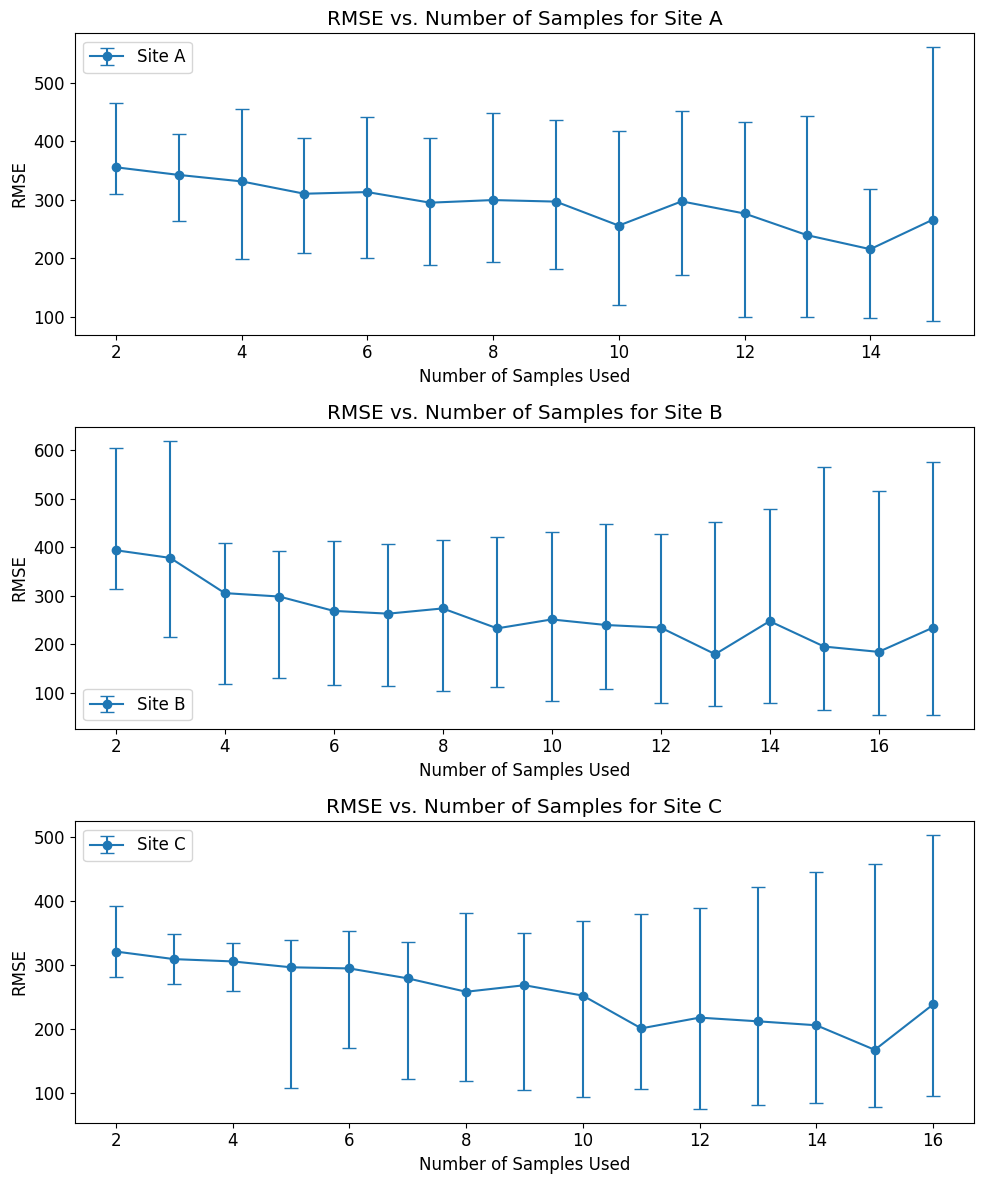

In [37]:
# Plotting the curves with subplots for each site in random_dictionary
fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # Adjust the figsize as needed
axes = axes.flatten()

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    print(rmse_mins)
    ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                fmt='-o', capsize=5, label=f'Site {site_id}')
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE')
    ax.set_title(f'RMSE vs. Number of Samples for Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Hide any unused subplots if random_dictionary has less than 3 sites
for i in range(len(random_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.show()



## Plot all together with baseline. Random bars are max and min values

Site A, Model A plotted
Site A, Model B plotted
Site A, Model C plotted
Site B, Model A plotted
Site B, Model B plotted
Site B, Model C plotted
Site C, Model A plotted
Site C, Model B plotted
Site C, Model C plotted


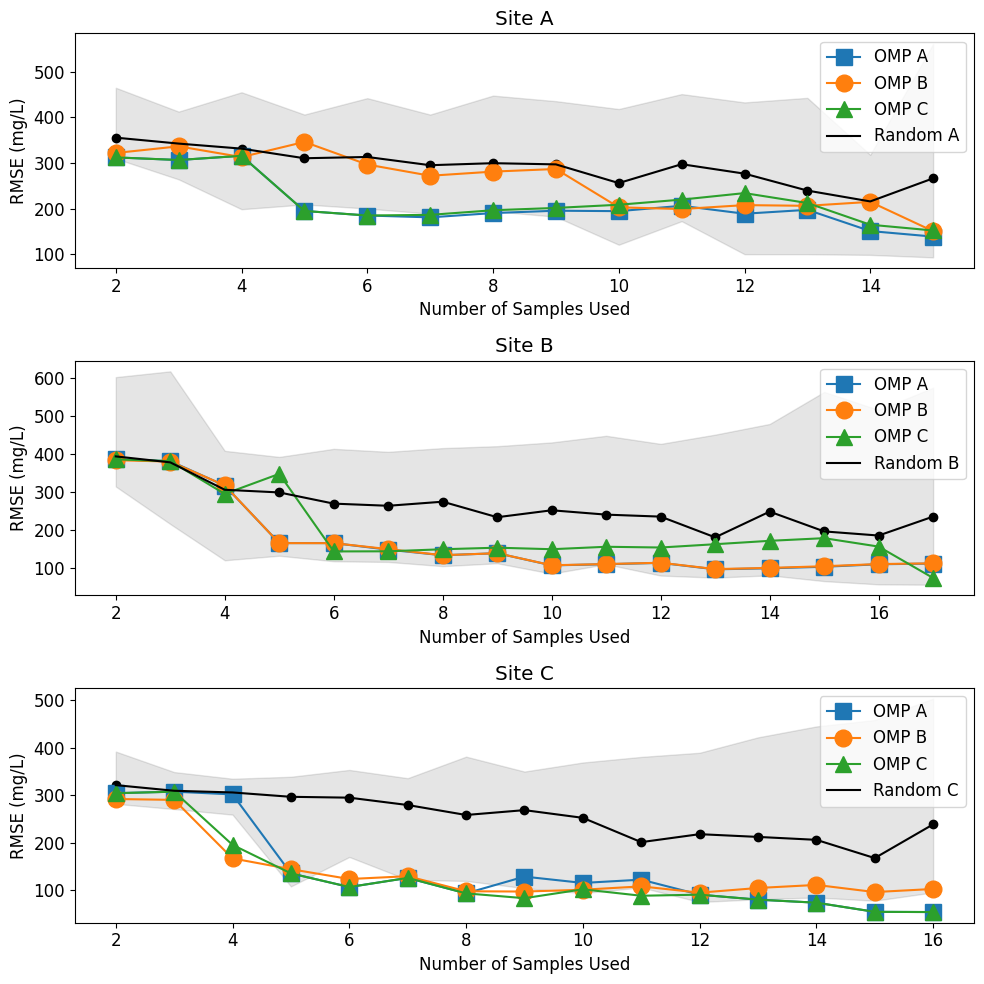

In [38]:
# Plotting the curves with subplots for each site in optimal_dictionary and random_dictionary
fig, axes = plt.subplots(3, 1, figsize=(10, 10))  

for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    for i, model_id in enumerate(alpha_site_id):
        if model_id not in optimal_dictionary[site_id]:
            continue
        
        rmses = []
        sample_counts = []
        
        for n in sorted(optimal_dictionary[site_id][model_id].keys()):
            rmse = optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            rmses.append(rmse)
            sample_counts.append(n)
        
        # Plot the curve
        ax.plot(sample_counts, rmses, linestyle='-', label=f'OMP {model_id}', marker = markers[i], markersize = '12')
        print(f'Site {site_id}, Model {model_id} plotted')

    sample_size = len(optimal_dictionary[site_id]['x_sort'])
    base_rmse = optimal_dictionary[site_id]['baseline_rmse']
    # ax.plot(range(sample_size), np.ones(sample_size)*base_rmse, color = 'red', linewidth = 3, label='baseline RMSE')

for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    # print(rmse_mins)
    # ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                # fmt='-o', capsize=5, label=f'Random {site_id}', color = 'black')
    # Plot the shaded error bounds
    ax.plot(sample_sizes, rmse_means, color='black',label=f'Random {site_id}')
    ax.scatter(sample_sizes, rmse_means, color='black')
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1)
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# Hide any unused subplots if optimal_dictionary has less than 3 sites
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
# plt.savefig('figures/RMSE_comparison.png', dpi=500)
plt.show()



# Time series prediction

[363.73223866 363.64559597 363.92438239 ... 359.48885723 359.5724023
 359.34152339]
[337.07773362 337.07773362 337.07773362 ... 337.07773362 337.07773362
 337.07773362]
[363.73223866 363.64559597 363.92438239 ... 359.48885723 359.5724023
 359.34152339]
[220.41289518 220.71449508 221.31591867 ... 219.08295989 219.1272206
 219.05486615]
[220.08681885 220.36834338 220.93448412 ... 218.91151923 218.94172113
 218.89828903]
[12.19238604 11.60230378 10.94175832 ... 18.82734282 18.25680915
 19.36272954]
[216.07429263 216.64633885 214.38453202 ... 205.56125033 206.10739212
 205.72153853]
[172.68543501 173.87797958 169.23740998 ... 153.55054155 154.38923506
 153.79467824]
[216.07429263 216.64633885 214.38453202 ... 205.56125033 206.10739212
 205.72153853]


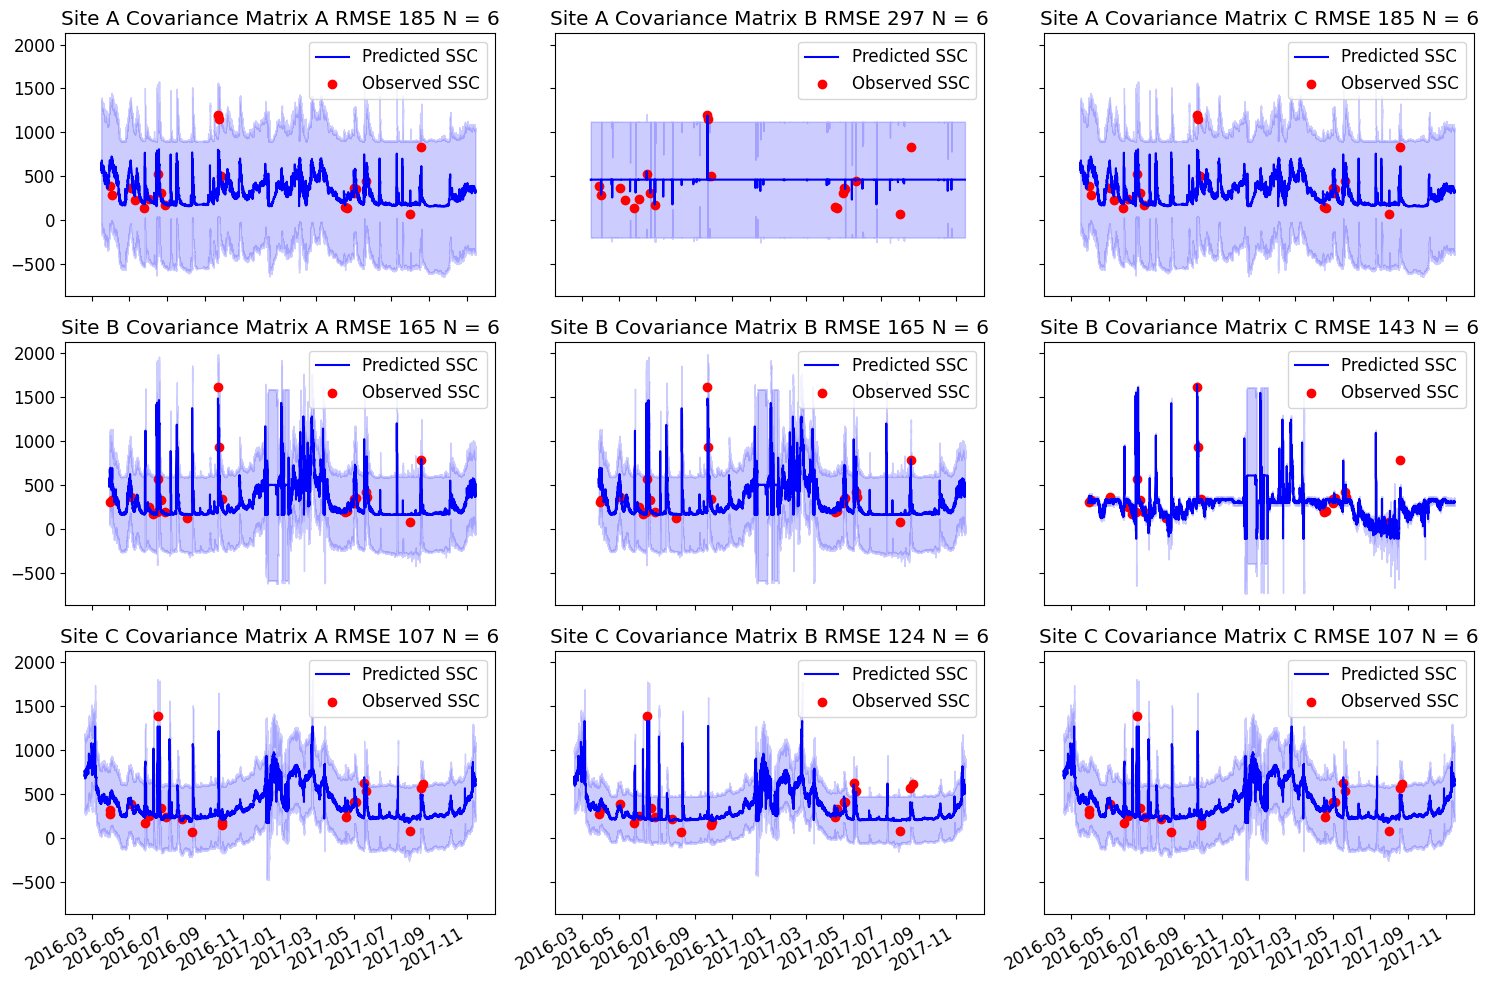

In [39]:
# Set up the 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()
# number samples to use for optimal training
n = 6
# Predict SSC using SAC data from `site_data[ADVM]`
plot_index = 0
for site_id in alpha_site_id:
    for i, cov_id in enumerate(alpha_site_id):
        # site_id = USGS_site_id[id]
        site_data = data_dictionary[site_id]
        advm_data = site_data['ADVM']
        sac_data = advm_data['SAC'].to_numpy()
        datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
        datetime_data = serialTimeToDatetime(datetime_num_data)


        # Use the GP model to predict SSC. This is the GP generated using covariance matrix of a site to select samples of another
        
        GP_model = optimal_dictionary[site_id][cov_id][n]['model']
        rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
        ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)
        print(ssc_std)
        # Plot the predictions
        ax = axes[plot_index]
        ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
        ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)
        
        # Match the sizes of x and y for observed data
        valid_indices = ~np.isnan(site_data['Samples']['SSC'])
        observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
        observed_dates = serialTimeToDatetime(observed_num_dates)
        observed_ssc = site_data['Samples']['SSC'][valid_indices]
        
        ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC')
        ax.set_title(f'Site {site_id} Covariance Matrix {cov_id} RMSE {rmse_opt:.0f} N = {n}')
        ax.legend()

        plot_index += 1

fig.tight_layout()
fig.autofmt_xdate()
fig.tight_layout()
plt.show()


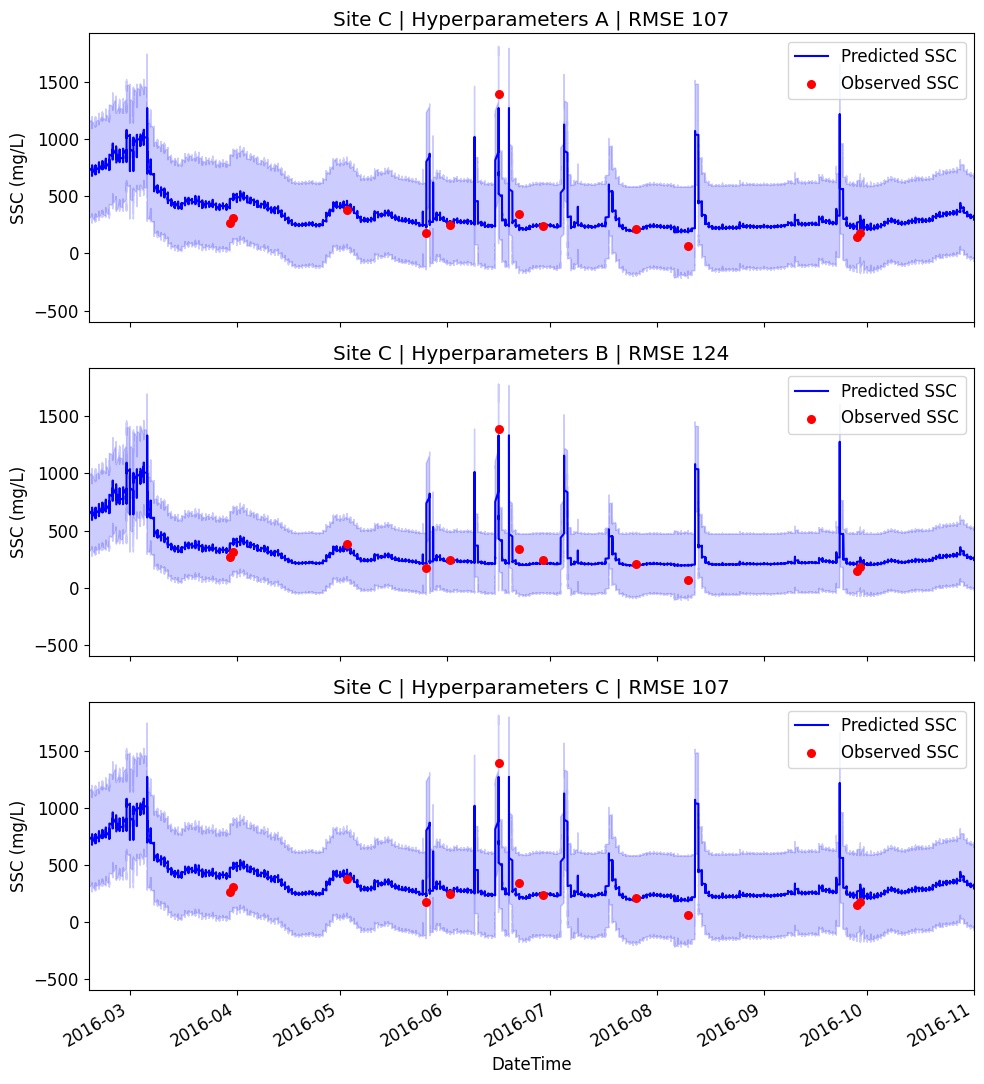

In [ ]:
# Only one column for Site C with different covariance matrices
fig, axes = plt.subplots(3, 1, figsize=(10, 11), sharex=True, sharey=True)
if not isinstance(axes, np.ndarray):  # In case there's only one subplot
    axes = [axes]

site_id = 'C'  # Fix to only Site C
n = 6  # Number of samples for optimal training

# Loop over different kernel covariance matrices (cov_id = A, B, C, etc.)
for i, cov_id in enumerate(alpha_site_id):
    site_data = data_dictionary[site_id]
    advm_data = site_data['ADVM']
    sac_data = advm_data['SAC'].to_numpy()
    datetime_num_data = advm_data['DateTime']  # Should be pandas datetime or datetime64
    datetime_data = serialTimeToDatetime(datetime_num_data)
    
    # GP model trained with samples from cov_id applied to Site C
    GP_model = optimal_dictionary[site_id][cov_id][n]['model']
    rmse_opt = optimal_dictionary[site_id][cov_id][n]['scores']['rmse']
    ssc_pred, ssc_std = GP_model.predict(sac_data.reshape(-1, 1), return_std=True)

    # Plotting
    ax = axes[i]
    ax.plot(datetime_data, ssc_pred, color='blue', label='Predicted SSC')
    ax.fill_between(datetime_data, ssc_pred - 1.96 * ssc_std, ssc_pred + 1.96 * ssc_std, color='blue', alpha=0.2)

    # Observed data
    valid_indices = ~np.isnan(site_data['Samples']['SSC'])
    observed_num_dates = site_data['Samples']['DateTime'][valid_indices]
    observed_dates = serialTimeToDatetime(observed_num_dates)

    observed_ssc = site_data['Samples']['SSC'][valid_indices]
    ax.scatter(observed_dates, observed_ssc, color='red', label='Observed SSC', s=30, zorder=10)

    ax.set_title(f'Site {site_id} | Hyperparameters {cov_id} | RMSE {rmse_opt:.0f}')
    ax.legend()
    ax.set_xlabel("DateTime")
    
    ax.set_ylabel("SSC (mg/L)")


# Set x-axis limit to the November 2016
date_cutoff = datetime(2016, 11, 1)
ax.set_xlim([datetime_data[0], date_cutoff])
fig.autofmt_xdate()
fig.tight_layout()
# plt.savefig('figures/Site3_SSC.png', dpi=500)
plt.show()


# active learning

In [41]:
from pathlib import Path
import time
# import scipy.io
# import shutil

# ==== Config ====
PROJECT_ROOT = Path.cwd()
BASE_DIR = PROJECT_ROOT
DATASET_NAME = "GVR_USGS"  # or "GVR_LISST"
DATASET_DIR = BASE_DIR / DATASET_NAME
FLAGS_DIR = BASE_DIR / "flags"
SELECTION_HISTORY_DIR = DATASET_DIR / "selection_history"

# Create directories
FLAGS_DIR.mkdir(exist_ok=True, parents=True)
DATASET_DIR.mkdir(exist_ok=True, parents=True)
SELECTION_HISTORY_DIR.mkdir(exist_ok=True, parents=True)

# File flags
FLAG_PYTHON_READY = FLAGS_DIR / "ready_for_matlab.txt"
FLAG_MATLAB_READY = FLAGS_DIR / "ready_for_python.txt"

# Sample tracking
sample_limit_fraction = 0.8
num_select_each_round = 3
adaptive_learning = {}

def wait_for_file(path):
    print(f"⏳ Waiting for: {path}")
    while not path.exists():
        time.sleep(1)
    print(f"✅ Found: {path}")

def remove_file(path):
    if path.exists():
        path.unlink()

In [87]:
selection_history = {site_id: [] for site_id in alpha_site_id}
num_step = 5

def adaptive_sample_loop():
    for site_id in alpha_site_id:
        all_data = model_dictionary[site_id]
        all_x = all_data['x']
        all_y = all_data['y']
        num_total = len(all_x)
        sample_limit = int(np.ceil(num_total * sample_limit_fraction))
        print(f"\n🔁 Site {site_id}: max {sample_limit} samples to be used.")

        current_selected = []
        selection_history[site_id] = []

        baseline_rmse = all_data['scores']['rmse']
        baseline_l = all_data['hyperparams']['rbf_l']
        baseline_nw = all_data['hyperparams']['noise_l']

        # sort data
        ord = np.argsort(all_x)
        all_x_sort = all_x[ord] 
        all_y_sort = all_y[ord]

        # All possible x values saved for MATLAB to read
        scipy.io.savemat(DATASET_DIR / f"xdata_samp{site_id}.mat", {"xdata": all_x_sort.reshape(-1, 1)})

        adaptive_learning[site_id] = {
            'num_total': num_total,
            'sample_limit': sample_limit,
            'x_sort' : all_x_sort,
            'y_sort' : all_y_sort,
            'baseline_rmse' : baseline_rmse,
            'baseline_hyperparams': {
                                        'rbf_l' : baseline_l,
                                        'noise_l' : baseline_nw,
                                    },
        }
        
        for model_id in alpha_site_id: 
            adaptive_learning[site_id][model_id] = {}
            current_selected = []
            n_used = len(current_selected)
        
            # initialize the adaptive learning dictionary for the site and model. we start with just the hyperparameters from the model site
            adaptive_learning[site_id][model_id][n_used]= {
                'hyperparams': model_dictionary[model_id]['hyperparams'],
                'xtrain': [],
            }
            print(f'current selected: {current_selected}')

            while len(current_selected) <= sample_limit:
                n_used = len(current_selected)
                print(f"  Samples used so far: {n_used}")

                # Create and save correlation matrix 
                # grab the length scales for the last run
                ker = adaptive_learning[site_id][model_id][n_used]['hyperparams']
                l = ker['rbf_l']
                nw = ker['noise_l']
                # Initialize the RBF kernel matrix
                rbf = np.zeros((num_total, num_total))

                # Compute the RBF kernel matrix
                for i, x in enumerate(all_x_sort):
                    for j, y in enumerate(all_x_sort):
                        rbf[i, j] = rbf_ker(x, y, l)

                # Add white noise to the diagonal
                wn = np.identity(num_total) * nw
                kernnie = rbf + wn

                # Compute the correlation matrix
                cor_mat = cov_to_cor(kernnie)

                corr_fname = f"corr_samp{site_id}{model_id}_{n_used}.mat"
                
                selected_indices = np.array(current_selected) + 1
                xdata_fname = f"xselect_samp{site_id}{model_id}_{n_used}.mat"
                scipy.io.savemat(DATASET_DIR / corr_fname, {"cor_mat": cor_mat})
                scipy.io.savemat(DATASET_DIR / xdata_fname, {"xdata": selected_indices})

                '''Create MATLAB flag and wait'''
                FLAG_PYTHON_READY.write_text("go")
                wait_for_file(FLAG_MATLAB_READY)

                # Load MATLAB-selected samples
                # if  n_used + num_step > sample_limit:
                #     selected_mat = f"xdata_samp{site_id}{model_id}_{sample_limit}.mat"
                
                # else:
                selected_mat = f"xdata_samp{site_id}{model_id}_{n_used+num_step}.mat"
                
                
                mat_data = scipy.io.loadmat(DATASET_DIR / selected_mat)
                new_selected = (mat_data["A"][0] - 1).astype(int)  # Adjust for MATLAB 1-based

                current_selected += [i for i in new_selected if i not in current_selected]
                selection_history[site_id] = current_selected.copy()
                
                '''=== Train GP on current selected ==='''
                x_train = all_x[current_selected]
                y_train = all_y[current_selected]
                SAC_pred, SSC_pred, std, GP_score, GP_logmarg, GP_model = GP(x_train, y_train, p)

                l_new, nw_new = np.exp(GP_model.kernel_.theta)

                # Predict on remaining data
                test_idx = [i for i in range(num_total) if i not in current_selected]
                x_test = all_x[test_idx]
                y_test = all_y[test_idx]
                ypred, std_pred = GP_model.predict(x_test.reshape(-1, 1), return_std=True)
                MSE = np.mean((y_test - ypred) ** 2)
                rmse = np.sqrt(MSE)
                r_score = GP_model.score(ypred.reshape(-1, 1), y_test.reshape(-1, 1))
                # Store into dictionary under new sample count
                adaptive_learning[site_id][model_id][len(current_selected)] = {
                    'hyperparams': {
                        'rbf_l': l_new,
                        'noise_l': nw_new,
                    },
                    'cor_matrix' : cor_mat,
                    'x_train': x_train,
                    'y_train': y_train,
                    'x_test': x_test,
                    'y_test': y_test,
                    'n_pred': ypred,
                    'p_pred': [SAC_pred, SSC_pred, std],
                    'scores': {
                        'GP_score': GP_score,
                        'GP_logmarg': GP_logmarg,
                        'r_score': r_score,
                        'rmse': rmse,
                        'std': std_pred,
                    },
                    'model': GP_model
                }

                # Save history
                np.save(SELECTION_HISTORY_DIR / f"{site_id}_selection.npy", np.array(current_selected))

                print(f"📈 Selected ({len(current_selected)}): {new_selected.tolist()}")

                remove_file(FLAG_PYTHON_READY)
                remove_file(FLAG_MATLAB_READY)
            print(f"✅ Done with model {model_id}")

        print(f"✅ Done with site {site_id}")

adaptive_sample_loop()


🔁 Site A: max 16 samples to be used.
current selected: []
  Samples used so far: 0
⏳ Waiting for: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
✅ Found: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
📈 Selected (5): [11, 3, 17, 6, 19]
  Samples used so far: 5
⏳ Waiting for: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


✅ Found: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
📈 Selected (9): [0, 1, 2, 3, 4]
  Samples used so far: 9
⏳ Waiting for: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
✅ Found: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
📈 Selected (14): [11, 3, 17, 6, 19, 0, 1, 2, 4, 16, 14, 10, 5, 12]
  Samples used so far: 14
⏳ Waiting for: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
✅ Found: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt
📈 Selected (19): [11, 3, 17, 6, 19, 0, 1, 2, 4, 16, 14, 10, 5, 12, 9, 7, 15, 18, 13]
✅ Done with model A
current selected: []
  Samples used so far: 0
⏳ Waiting for: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt


/Users/meagant/opt/miniconda3/envs/adap_samp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


✅ Found: /Users/meagant/GitHub/Soft_Sensor_OMP/flags/ready_for_python.txt


OSError: Reader needs file name or open file-like object

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([0, 3, 6, 9, 12, 15, 18])
dict_keys([0, 3, 6, 9, 12, 15, 18])


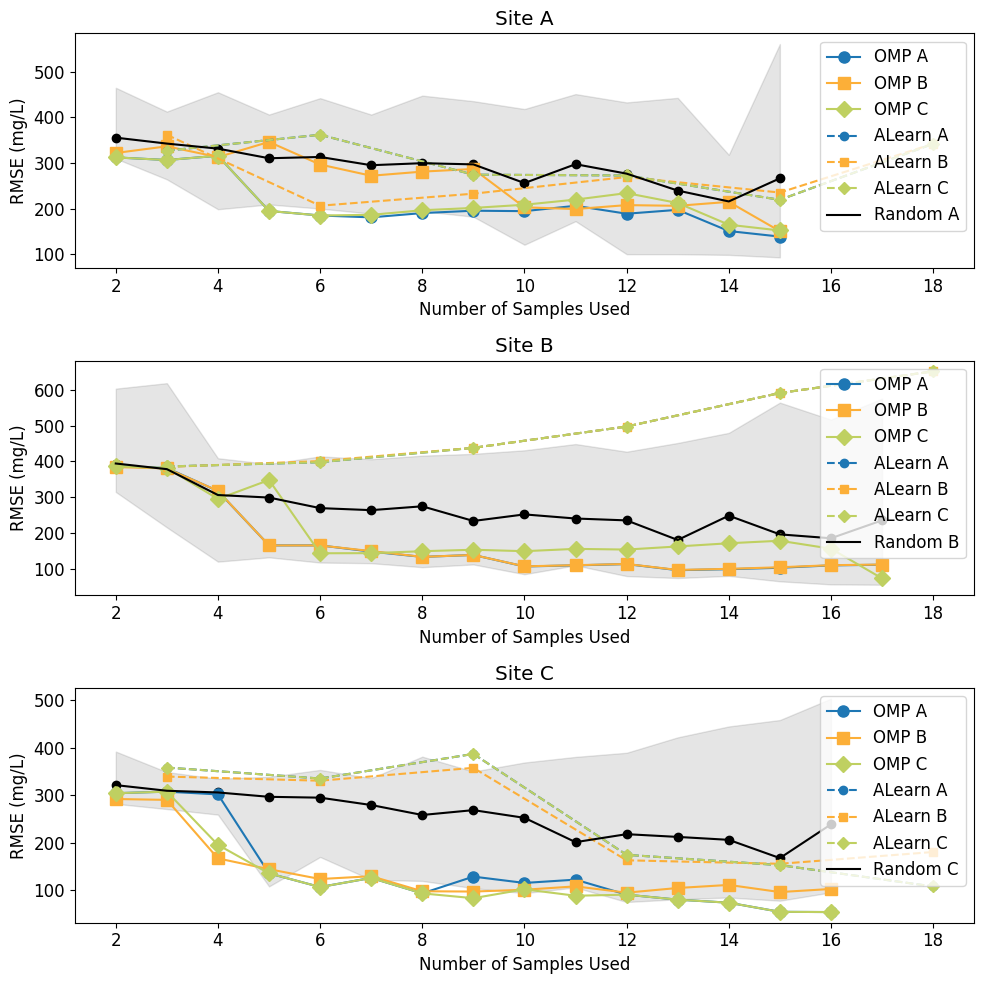

In [69]:

markers = ['o', 's', 'D', '^', 'v',  '>']

fig, axes = plt.subplots(3, 1, figsize=(10, 10))

for idx, site_id in enumerate(optimal_dictionary.keys()):
    if idx >= len(axes):
        break

    ax = axes[idx]

    # === Plot OMP ===
    for i, model_id in enumerate(alpha_site_id):
        print(optimal_dictionary[site_id][model_id].keys())
        if model_id not in optimal_dictionary[site_id]:
            continue

        sample_counts = sorted(optimal_dictionary[site_id][model_id].keys())
        rmse_values = [
            optimal_dictionary[site_id][model_id][n]['scores']['rmse']
            for n in sample_counts
        ]

        ax.plot(sample_counts, rmse_values, linestyle='-', color=colr_sc[i],
                label=f'OMP {model_id}', marker=markers[i], markersize=8)

    # === Plot Adaptive Learning ===
    if site_id in adaptive_learning:
        for i, model_id in enumerate(alpha_site_id):
            print(adaptive_learning[site_id][model_id].keys())
            if model_id not in adaptive_learning[site_id]:
                continue

            al_rmse = []
            al_counts = []

            for n in sorted(adaptive_learning[site_id][model_id].keys()):
                entry = adaptive_learning[site_id][model_id][n]
                if 'scores' in entry:
                    al_rmse.append(entry['scores']['rmse'])
                    al_counts.append(n)

            if al_rmse:
                ax.plot(al_counts, al_rmse, linestyle='--', color=colr_sc[i],
                        label=f'ALearn {model_id}', marker=markers[i], markersize=6)

# === Plot Random Sampling ===
for idx, site_id in enumerate(random_dictionary.keys()):
    if idx >= len(axes):
        break  # In case there are more than 3 sites

    ax = axes[idx]
    
    sample_sizes = []
    rmse_means = []
    rmse_mins = []
    rmse_maxs = []

    for n in random_dictionary[site_id].keys():
        
        if isinstance(n, np.int64):
            # print(n)
            sample_sizes.append(n)
            rmse_means.append(random_dictionary[site_id][n]['rmse_mean'])
            rmse_mins.append(random_dictionary[site_id][n]['rmse_best'][0])
            rmse_maxs.append(random_dictionary[site_id][n]['rmse_worst'][0])

    # Plot the curve with error bars
    # print(rmse_mins)
    # ax.errorbar(sample_sizes, rmse_means, yerr=[np.array(rmse_means) - np.array(rmse_mins), np.array(rmse_maxs) - np.array(rmse_means)],
                # fmt='-o', capsize=5, label=f'Random {site_id}', color = 'black')
    # Plot the shaded error bounds
    ax.plot(sample_sizes, rmse_means, color='black',label=f'Random {site_id}')
    ax.scatter(sample_sizes, rmse_means, color='black')
    ax.fill_between(sample_sizes, rmse_mins, rmse_maxs, color='black', alpha=0.1)
    
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()

    # Force x-axis to have integer ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # === Plot formatting ===
    ax.set_xlabel('Number of Samples Used')
    ax.set_ylabel('RMSE (mg/L)')
    ax.set_title(f'Site {site_id}')
    ax.legend()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Hide unused subplots
for i in range(len(optimal_dictionary), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()
